# Imports

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division
from collections import defaultdict
import matplotlib.pyplot as plt
from six.moves import range
import tensorflow as tf
from glob import glob
from PIL import Image
import pandas as pd
import numpy as np
import pickle

preprocessing_image = tf.keras.preprocessing.image
optimizers = tf.keras.optimizers 
datasets = tf.keras.datasets
metrics = tf.keras.metrics
layers = tf.keras.layers
models = tf.keras.models
losses = tf.keras.losses
utils = tf.keras.utils

# Load and Normalize Dataset

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from keras.utils import np_utils
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/MyDrive/Colab Notebooks/HW6/Dataset'

# dataset = np.zeros((5*201,32,32)) ; labels = np.zeros((5*201))
# index = np.arange(5*201) ; np.random.shuffle(index) ; r = 0
# for i in range(5): # len(os.listdir())
#   for j in range(201): 
#     img = np.array(mpimg.imread(f'Class {i+1}/{j}.png'))
#     dataset[int(index[r])] = img ; labels[int(index[r])] = i
#     r += 1
# np.save('./Dataset.npy',dataset) ; np.save('./Labels.npy',labels)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/HW6/Dataset


In [ ]:
dataset = np.load('./Dataset.npy') ; labels = np.load('./Labels.npy')
dataset = (dataset.astype('float32') - 127.5) / 127.5 ; labels = labels.astype('uint8')
dataset = np.expand_dims(dataset, axis=-1) ; # labels = np_utils.to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
nb_train, nb_test = X_train.shape[0], X_test.shape[0]

# Construct Generator

In [ ]:
def generator(latent_size, classes=5):
    def up_sampling_block(x, filter_size):
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = layers.Conv2D(filter_size, (5, 5), padding='same', activation='relu')(x)
        return x
    # Input 1
    # image class label
    image_class = layers.Input(shape=(1,), dtype='int32', name='image_class')
    # class embeddings
    emb = layers.Embedding(classes, latent_size, embeddings_initializer='glorot_normal')(image_class)
    # 5 classes in dataset
    cls = layers.Flatten()(emb)
    # Input 2
    # latent noise vector
    latent_input = layers.Input(shape=(latent_size,), name='latent_noise')
    # hadamard product between latent embedding and a class conditional embedding
    h = layers.multiply([latent_input, cls])
    # Conv generator
    x = layers.Dense(1024, activation='relu')(h)
    x = layers.Dense(128 * 8 * 8, activation='relu')(x)
    x = layers.Reshape((8, 8, 128))(x)
    # upsample to (16, 16, 128)
    x = up_sampling_block(x, 256)
    # upsample to (32, 32, 256)
    x = up_sampling_block(x, 128)
    # reduce channel into binary image (32, 32, 1)
    generated_img = layers.Conv2D(1, (2,2), padding='same', activation='tanh')(x)
    return models.Model(inputs=[latent_input, image_class], outputs=generated_img, name='generator') 

# Construct Discriminator

In [ ]:
def discriminator(input_shape=(32, 32, 1)):
    def conv_block(x, filter_size, stride):
        x = layers.Conv2D(filter_size, (5,5), padding='same', strides=stride)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)
        return x
    input_img = layers.Input(shape=input_shape)
    x = conv_block(input_img, 32, (2,2))
    x = conv_block(x, 64, (2,2))
    x = conv_block(x, 128, (2,2))
    x = conv_block(x, 256, (2,2))
    features = layers.Flatten()(x)
    # binary classifier, image fake or real
    fake = layers.Dense(1, activation='sigmoid', name='generation')(features)
    # multi-class classifier, image digit class
    aux = layers.Dense(5, activation='softmax', name='auxiliary')(features)
    return models.Model(inputs=input_img, outputs=[fake, aux], name='discriminator')

# Combine Generator with Discriminator

In [ ]:
# Adam parameters suggested in paper
adam_lr = 0.0001
adam_beta_1 = 0.5

def ACGAN(latent_size = 100):
    # build the discriminator
    dis = discriminator()
    dis.compile(optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1), loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])
    # build the generator
    gen = generator(latent_size)
    gen.compile(optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1), loss='binary_crossentropy')
    # Inputs
    latent = layers.Input(shape=(latent_size, ), name='latent_noise')
    image_class = layers.Input(shape=(1,), dtype='int32', name='image_class')
    # Get a fake image
    fake_img = gen([latent, image_class])
    # Only train generator in combined model
    dis.trainable = False
    fake, aux = dis(fake_img)
    combined = models.Model(inputs=[latent, image_class], outputs=[fake, aux], name='ACGAN')
    combined.compile(optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1), loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])
    return combined, dis, gen

# Training Helper Functions

In [ ]:
def print_logs(metrics_names, train_history, test_history):
    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format('component', *metrics_names))
    print('-' * 65)
    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)', *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)', *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)', *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)', *test_history['discriminator'][-1]))
    
def generate_batch_noise_and_labels(batch_size, latent_size):
    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_size))
    # sample some labels
    sampled_labels = np.random.randint(0, 5, batch_size)
    return noise, sampled_labels

# Train and Evaluate ACGAN

In [ ]:
nb_epochs = 100 ; batch_size = 2 ; latent_size = 100
train_history = defaultdict(list) ; test_history = defaultdict(list)
combined, dis, gen = ACGAN(latent_size = 100)

for epoch in range(nb_epochs):
    print('Epoch {} of {}'.format(epoch + 1, nb_epochs))
    nb_batches = int(X_train.shape[0] / batch_size)
    progress_bar = utils.Progbar(target=nb_batches)
    epoch_gen_loss = [] ; epoch_disc_loss = []
    for index in range(nb_batches):
        progress_bar.update(index)
        ### Train Discriminator ###
        # generate noise and labels
        noise, sampled_labels = generate_batch_noise_and_labels(batch_size, latent_size=100)
        # generate a batch of fake images, using the generated labels as a conditioner
        generated_images = gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)
        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]
        # construct discriminator dataset
        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)
        # train discriminator
        epoch_disc_loss.append(dis.train_on_batch(X, [y, aux_y]))
        ### Train Generator ###
        # generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator       
        noise, sampled_labels = generate_batch_noise_and_labels(2 * batch_size, latent_size=100)
        # we want to train the generator to trick the discriminator
        # so all the labels should be not-fake (1)
        trick = np.ones(2 * batch_size)
        epoch_gen_loss.append(combined.train_on_batch([noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))
    print('\nTesting for epoch {}:'.format(epoch + 1))
    ### Evaluate Discriminator ###
    # generate a new batch of noise
    noise, sampled_labels = generate_batch_noise_and_labels(nb_test, latent_size=100)
    # generate images
    generated_images = gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=False)
    # construct discriminator evaluation dataset
    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)
    # evaluate discriminator
    # test loss
    discriminator_test_loss = dis.evaluate(X, [y, aux_y], verbose=False)
    # train loss
    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)
    ### Evaluate Generator ###
    # make new noise
    noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_test, latent_size=100)
    # create labels
    trick = np.ones(2 * nb_test)
    # evaluate generator
    # test loss
    generator_test_loss = combined.evaluate([noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels], verbose=False)
    # train loss
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
    ### Save Losses per Epoch ###
    # append train losses
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)
    # append test losses
    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)
    # print training and test losses
    print_logs(dis.metrics_names, train_history, test_history)
    # save weights every epoch
    gen.save_weights('./params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    dis.save_weights('./params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

# Save train test loss history
pickle.dump({'train': train_history, 'test': test_history}, open('./acgan-history.pkl', 'wb'))

Epoch 1 of 100
401/402 [============================>.] - ETA: 0s
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.29 | 0.68            | 1.61 
generator (test)       | 2.31 | 0.70            | 1.61 
discriminator (train)  | 2.31 | 0.69            | 1.62 
discriminator (test)   | 2.31 | 0.69            | 1.62 
Epoch 2 of 100
401/402 [============================>.] - ETA: 0s
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.31 | 0.70            | 1.61 
generator (test)       | 2.32 | 0.70            | 1.61 
discriminator (train)  | 2.31 | 0.69            | 1.61 
discriminator (test)   | 2.30 | 0.69            | 1.61 
Epoch 3 of 100
401/402 [============================>.] - ETA: 0s
Testing for epoch 3:
component              | loss

# Loss History

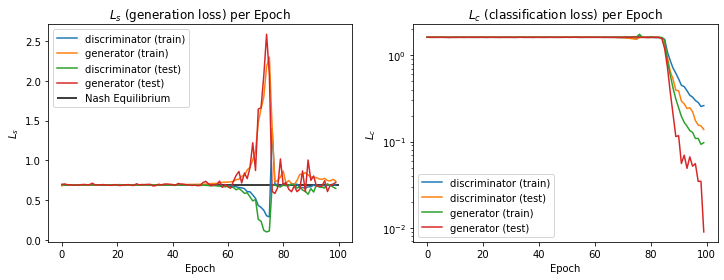

In [ ]:
hist = pickle.load(open('./acgan-history.pkl','rb')) ; print(''); plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'generation_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.title(r'$L_s$ (generation loss) per Epoch') ; plt.legend() ; plt.xlabel('Epoch') ; plt.ylabel(r'$L_s$')

plt.subplot(1,2,2)
for g in ['discriminator', 'generator']:
    for p in ['train', 'test']:
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))
plt.title(r'$L_c$ (classification loss) per Epoch') ; plt.legend() ; plt.xlabel('Epoch') ; plt.ylabel(r'$L_c$') ; plt.semilogy() ; plt.show()

# Generate Digits Conditioned on Class Label

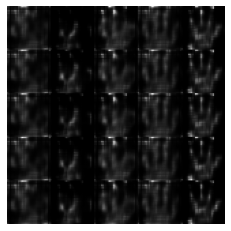

In [ ]:
# load the weights from the last epoch
gen.load_weights(sorted(glob('./params_generator*'))[-1])
# construct batch of noise and labels
noise = np.tile(np.random.uniform(-1, 1, (5, latent_size)), (5, 1))
sampled_labels = np.array([[i] * 5 for i in range(5)]).reshape(-1, 1)
# generate digits
generated_images = gen.predict([noise, sampled_labels], verbose=0)
# arrange them into a grid and un-normalize the pixels
img = (np.concatenate([r.reshape(-1, 32) for r in np.split(generated_images, 5)], axis=-1))
# plot images
plt.imshow(img, cmap='gray')
_ = plt.axis('off')